In [1]:
# Copy of fake_detection.ipynb but with sid_extragal_short_gr_100_rchi2min3.dat data set
# Find most realistic simulations to real ztf_dr4 data

In [2]:
%matplotlib inline

import time
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd

from coniferest.isoforest import IsolationForest
from coniferest.pineforest import PineForest

from pathlib import Path

import os
import sys
from validutils_zwad.read_data import read_data

%config InlineBackend.figure_format = 'retina'

In [3]:
%%time

# Read in light curves of fakes...see how convincing they are

ZTF_FILTERS = 'gr'
# using simlib from data
X42, y42 = read_data('./ztf_dr3_sim_data/ZTF_SIMS_ALLMODELS_3RD_RUN/PALEO_ZTF_MODEL42_SNII-NMF.pkl.gz')
X60, y60 = read_data('./ztf_dr3_sim_data/ZTF_SIMS_ALLMODELS_3RD_RUN/PALEO_ZTF_MODEL60_SLSN-I.pkl.gz')
X62, y62 = read_data('./ztf_dr3_sim_data/ZTF_SIMS_ALLMODELS_3RD_RUN/PALEO_ZTF_MODEL62_SNIbc-MOSFIT.pkl.gz')
X64, y64 = read_data('./ztf_dr3_sim_data/ZTF_SIMS_ALLMODELS_3RD_RUN/PALEO_ZTF_MODEL64_TDE.pkl.gz')
X90, y90 = read_data('./ztf_dr3_sim_data/ZTF_SIMS_ALLMODELS_3RD_RUN/PALEO_ZTF_MODEL90_SNIa-SALT2.pkl.gz')

CPU times: user 1min 50s, sys: 6.55 s, total: 1min 57s
Wall time: 1min 58s


In [42]:
def plot_lightcurves_id(idx, X, f, compare_file):    
    
    nrows,ncols = 1,2
    figsize=(8, 4)
    
    fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(8, 4), squeeze=False)
    plt.gca().invert_yaxis()
    
    flux = []
    for f in ZTF_FILTERS:
        if len(X.loc[idx]['fluxcal_' + f]) > 0:
            flux.append(max(X.loc[idx]['fluxcal_' + f]))
            
    if compare_file is not None:
        real_SNIa = pd.read_csv(compare_file)
        peakmag = np.min(real_SNIa['Mag'])
        peakmjd = real_SNIa.loc[real_SNIa['Mag']==peakmag]['MJD']
        real_SNIa['FromPeak'] = real_SNIa['MJD'] - peakmjd.values

        # Turn mag to calibrated flux (fluxcal=10**(-0.4·mag+11))
        real_SNIa_g = real_SNIa[real_SNIa['Filter']=='g']
        real_SNIa_r = real_SNIa[real_SNIa['Filter']=='R']
        
        ax[0,0].errorbar(real_SNIa_g['FromPeak'], real_SNIa_g['Mag'], real_SNIa_g['MagErr'],
                            fmt='+', label='{}'.format(compare_file[:-4]))
        ax[0,1].errorbar(real_SNIa_r['FromPeak'], real_SNIa_r['Mag'], real_SNIa_r['MagErr'],
                            fmt='+', label='{}'.format(compare_file[:-4]))

        
        
        for i, (axi, f) in enumerate(zip(ax.flat, ZTF_FILTERS)):
            
            
            axi.errorbar(X.loc[idx]['mjd_%s' % f] - X.loc[idx]['pkmjd'], 
                            X.loc[idx]['mag_%s' % f], X.loc[idx]['magerr_%s' % f], 
                            fmt='+', label='Model = {}, #OBS= {}'.format(X.loc[idx]['SIM_MODEL_NAME'].replace(' ', ''), len(X.loc[idx]['mjd_%s' % f]))) 
            

            rowid = i // ncols
            colid = i % ncols
            #axi.set_xlim(-100,300)
            #axi.set_ylim(np.max(X.loc[idx]['mag_%s' % f]), np.min(X.loc[idx]['mag_%s' % f]))
            axi.set_ylim(23,16)
            axi.set_xlabel('MJD')
            axi.set_ylabel('Magnitude')
            axi.set_title('ID = {}, {}-band'.format(X.loc[idx]['snid'], f))
            ax[0,0].legend(loc='upper right', bbox_to_anchor=(0.5, -0.15), ncol=2, fancybox=True, shadow=True, fontsize=12)
            ax[0,1].legend(loc='upper right', bbox_to_anchor=(0.6, -0.15), ncol=2, fancybox=True, shadow=True, fontsize=12)

    if compare_file is None:

        for i, (axi, f) in enumerate(zip(ax.flat, ZTF_FILTERS)):
            axi.errorbar(X.loc[idx]['mjd_%s' % f] - X.loc[idx]['pkmjd'], 
                            X.loc[idx]['mag_%s' % f], X.loc[idx]['magerr_%s' % f], 
                            fmt='+', label='Model = {}, #OBS= {}'.format(X.loc[idx]['SIM_MODEL_NAME'].replace(' ', ''), len(X.loc[idx]['mjd_%s' % f]))) 

            rowid = i // ncols
            colid = i % ncols
            #axi.set_xlim(-100,200)
            #axi.set_ylim(25,16)
            axi.set_xlabel('MJD')
            axi.set_ylabel('Magnitude')
            axi.set_title('ID = {}, {}-band'.format(X.loc[idx]['snid'], f))
            ax[0,0].legend(loc='upper right', bbox_to_anchor=(0.9, -0.15), ncol=2, fancybox=True, shadow=True, fontsize=12)
            ax[0,1].legend(loc='upper right', bbox_to_anchor=(1.3, -0.15), ncol=2, fancybox=True, shadow=True, fontsize=12)

In [5]:
# First of all: load data

from zwad.utils import load_data

def feature_file(oid_file):
    parent = oid_file.parent
    if oid_file.name.startswith('oid_'):
        name = oid_file.name.replace('oid_', 'feature_')
    else:
        name = oid_file.name.replace('sid_', 'feature_')
    
    return parent.joinpath(name)
    

datadir = Path('../features_data', 'dr4_new')
sid_extragal_gr = datadir.joinpath('sid_extragal_short_gr_100_rchi2min3.dat')
feature_extragal_gr = feature_file(sid_extragal_gr)

fakesdir = Path('../sim_fake', 'output')
sid_fakes = list(fakesdir.glob('oid_*.dat'))
feature_fakes = [feature_file(s) for s in sid_fakes]


fakesids, fakefeatures = load_data(sid_fakes, feature_fakes)
dr4sids, dr4features = load_data([sid_extragal_gr], [feature_extragal_gr])
sids, features = load_data([sid_extragal_gr] + sid_fakes, [feature_extragal_gr] + feature_fakes)

In [6]:
sid_fakes

[PosixPath('../sim_fake/output/oid_sim_62_SNIbc.dat'),
 PosixPath('../sim_fake/output/oid_sim_42_SNII-NMF.dat'),
 PosixPath('../sim_fake/output/oid_sim_64_TDE.dat'),
 PosixPath('../sim_fake/output/oid_sim_90_SNIa.dat'),
 PosixPath('../sim_fake/output/oid_sim_60_SLSN-I.dat')]

### Perform coniferest IF on all features

In [7]:
%%time

# Perform calculations of outliers

isoforest = IsolationForest(n_subsamples=1024, n_trees=1000) # n_subsamples=1024, n_trees=1000
isoforest.fit(features)
scores = isoforest.score_samples(features)
ordered_sids = sids[np.argsort(scores)]
detection_curve = np.cumsum(ordered_sids < 1e10)

CPU times: user 1min 37s, sys: 822 ms, total: 1min 37s
Wall time: 1min 39s


In [8]:
num_fakes = len(ordered_sids[ordered_sids < 1e10])
num_fakes

747

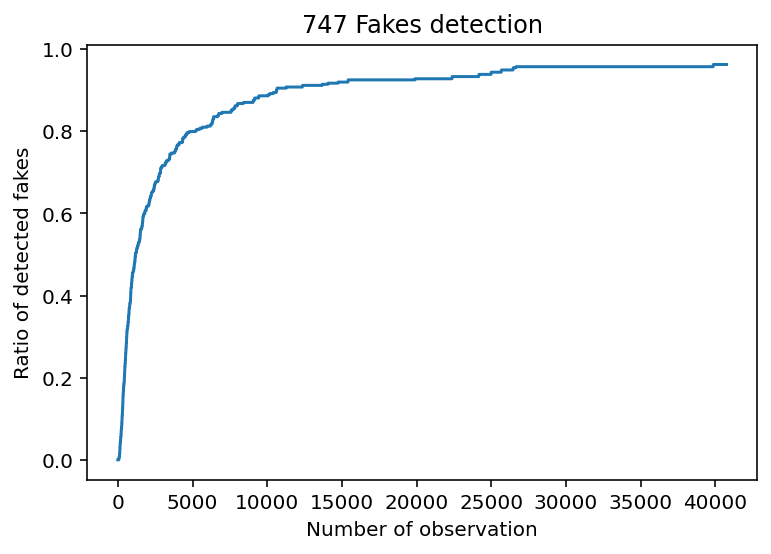

In [9]:
# Plot the detection curve

n_fakes = detection_curve[-1]

plt.plot(detection_curve[:n_fakes+40000]/num_fakes) # 10000 is for extragal_short_gr_100.tar
plt.xlabel('Number of observation')
plt.ylabel('Ratio of detected fakes')
plt.title(f'{num_fakes} Fakes detection')
pass

In [10]:
n_fakes - detection_curve[60000]

20

In [11]:
#n_fakes - detection_curve[1000000]

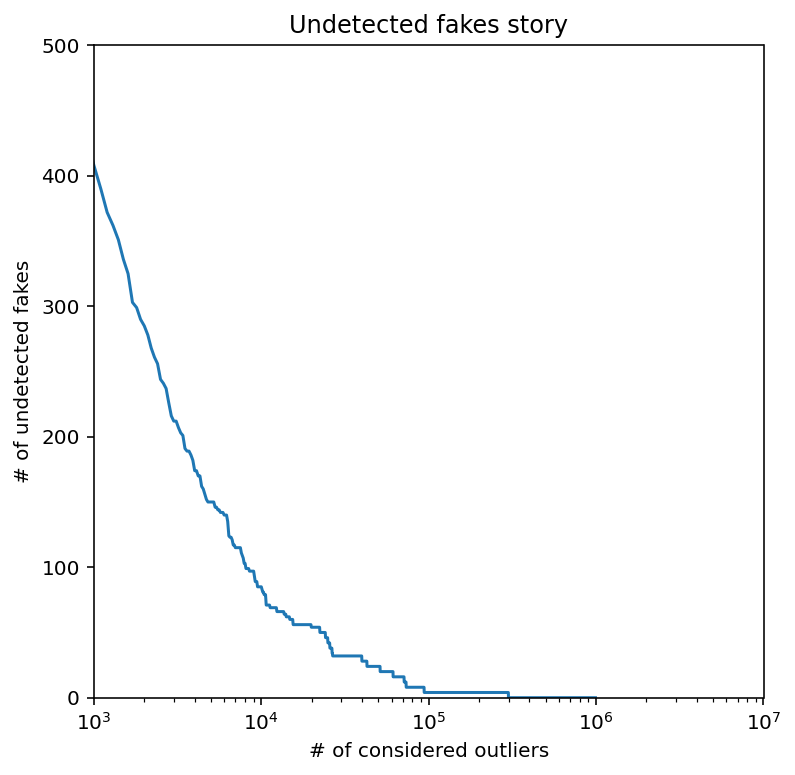

In [12]:
plt.figure(figsize=(6, 6))
plt.title('Undetected fakes story')
plt.plot(np.arange(0, len(detection_curve), 100), n_fakes - detection_curve[::100])
plt.xlabel('# of considered outliers')
plt.xlim(1e3, 1e7)
plt.xscale('log')
plt.ylabel('# of undetected fakes')
plt.ylim(0, 500)
pass

In [13]:
%%time

isoforest = IsolationForest(n_subsamples=1024, n_trees=10000)
isoforest.fit(features)
fake_trees = PineForest.filter_trees(isoforest.trees, features[-n_fakes:], np.full(n_fakes, -1), 9000)

CPU times: user 46.3 s, sys: 756 ms, total: 47 s
Wall time: 47.5 s


In [14]:
def get_most_frequent_roots(trees, n_hits=10):
    bins = np.bincount([tree.__getstate__()['nodes'][0]['feature'] for tree in trees])
    sort_index = np.argsort(bins)[::-1]
    sorted_bins = bins[sort_index]
    index = np.argwhere(sorted_bins >= n_hits).ravel()
    return sort_index[index]

In [15]:
roots = get_most_frequent_roots(fake_trees, n_hits=25) #30 in original returns none
roots

array([67, 14, 64, 94, 60, 11, 72,  7, 76, 59, 61,  8, 41])

In [16]:
feature_names = Path('../features_data', 'dr4_new', 'feature_extragal_short_gr_100_rchi2min3.name').open('r').read().split('\n')


def plot_feature_histogram(feature):
    values = features[:, feature]
    bins = np.linspace(values.min(), values.max(), 30)

    plt.figure()
    plt.title(f'Feature #{feature}({feature_names[feature]}) histogram')
    plt.hist(values[:-n_fakes], bins=bins, alpha=0.5, label='dr4')
    plt.hist(values[-n_fakes:], bins=bins, alpha=0.5, label='fakes')
    plt.yscale('log')
    plt.legend()
    
    dr4_value = values[:-n_fakes]
    fakes_value = values[-n_fakes:]
    
    return dr4_value, fakes_value, feature_names[feature]

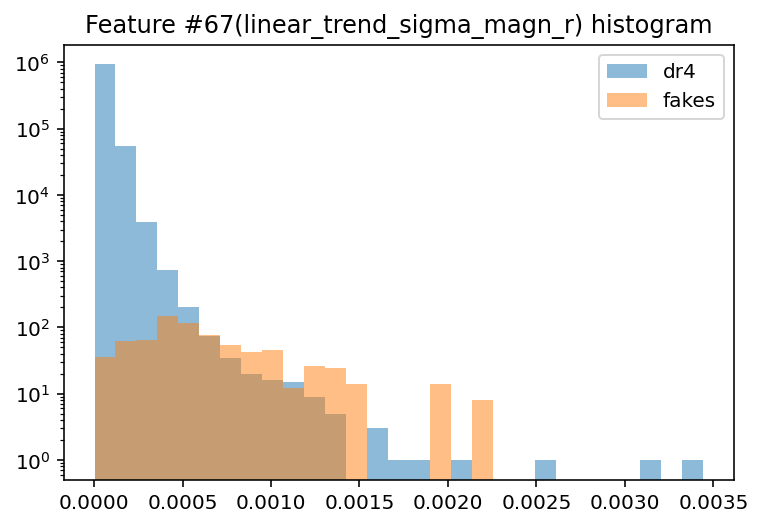

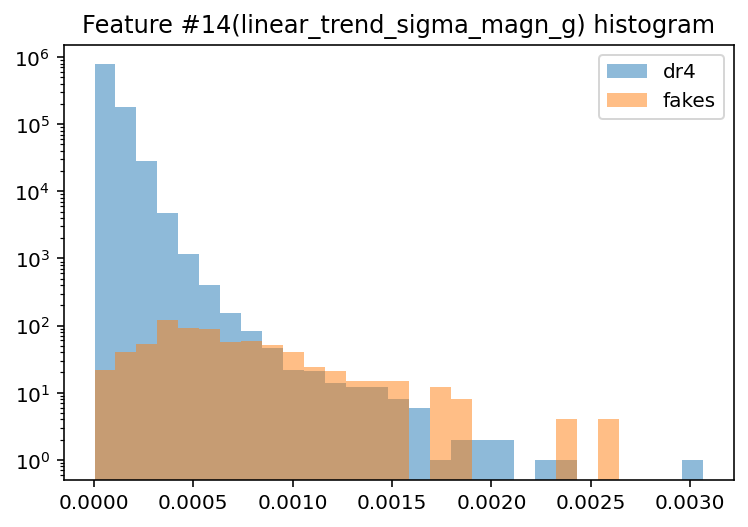

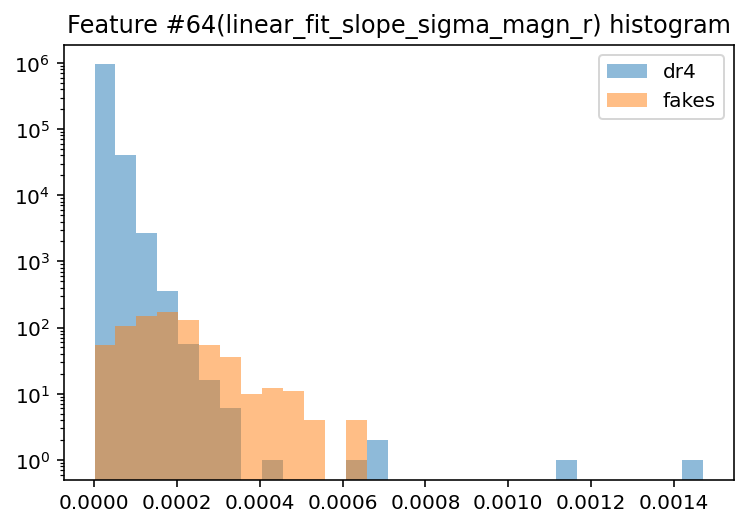

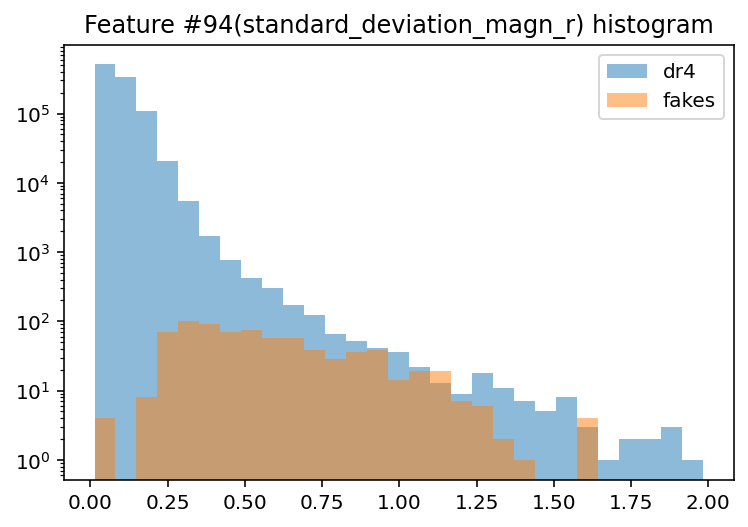

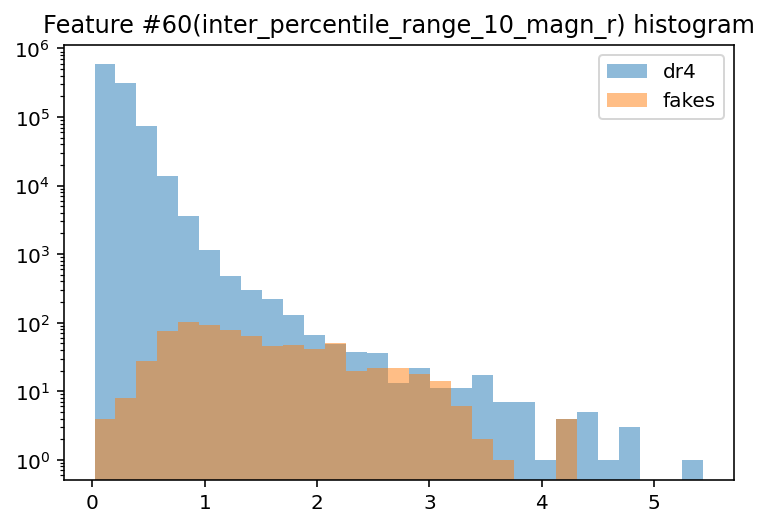

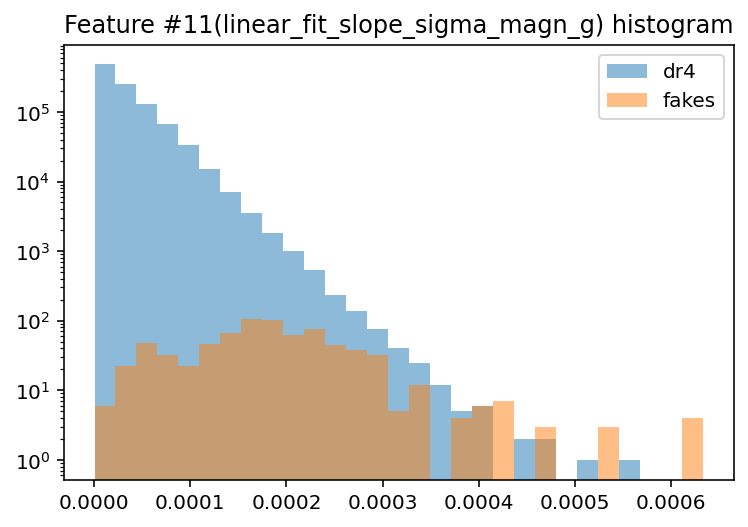

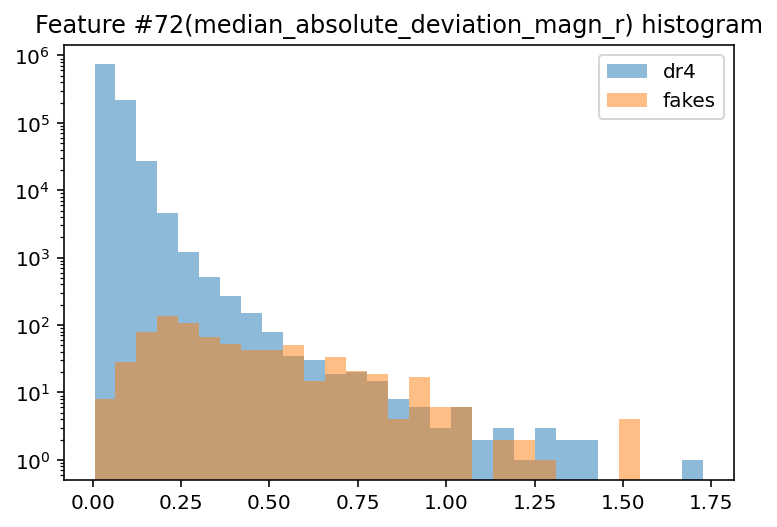

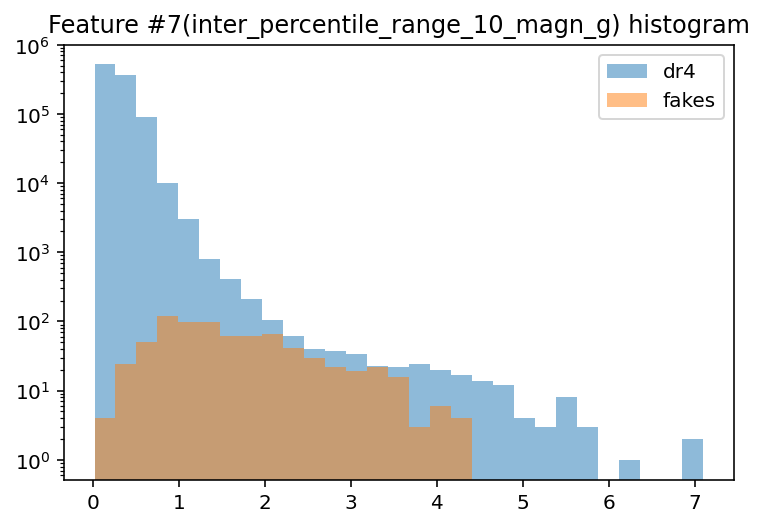

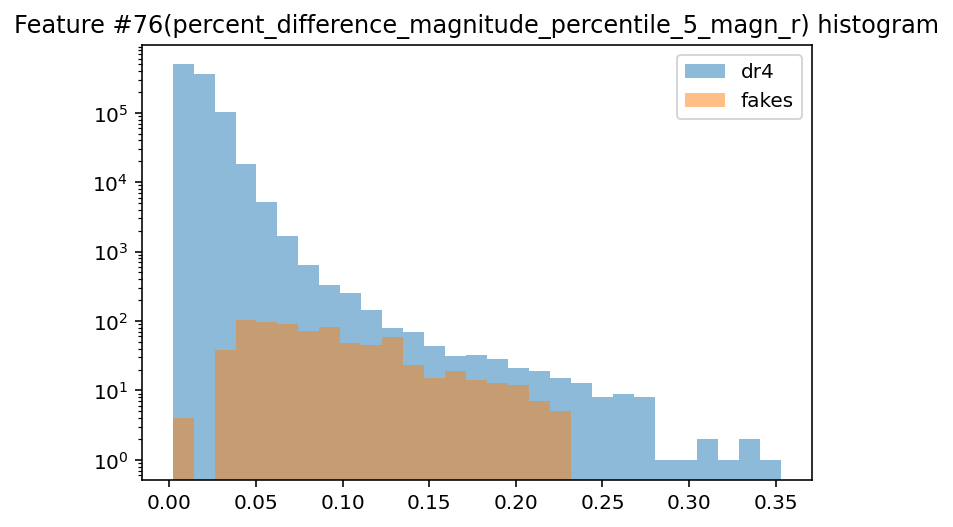

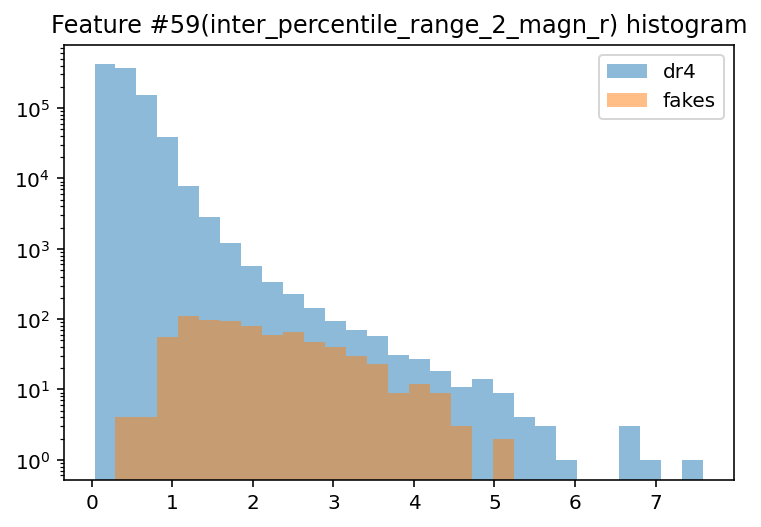

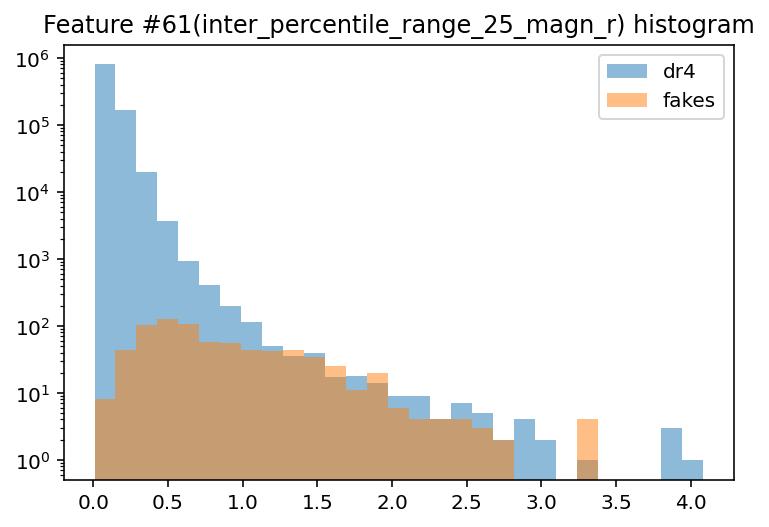

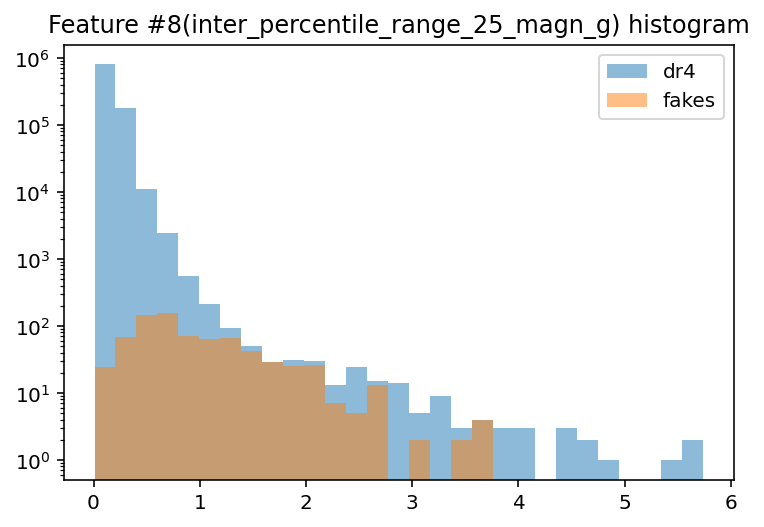

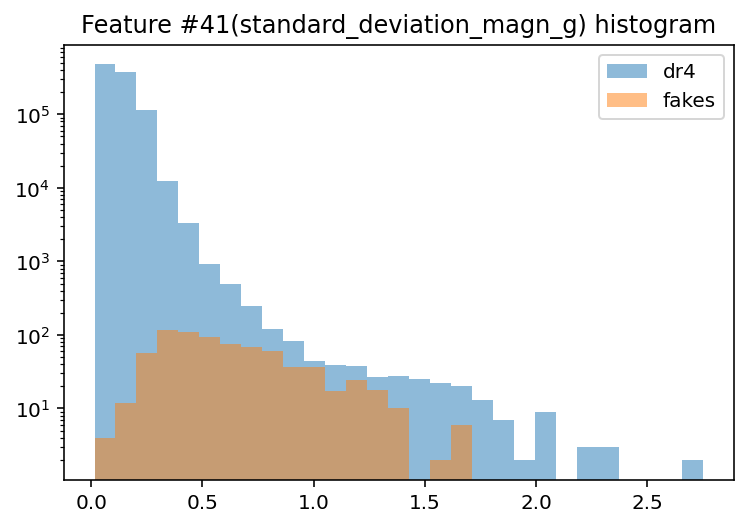

In [17]:
dr4_values_list, fakes_values_list, feature_list = [],[],[]

for root in roots:
    dr4_value, fakes_value, feature = plot_feature_histogram(root)
    plt.show()
    
    dr4_values_list.append(dr4_value)
    fakes_values_list.append(fakes_value)
    feature_list.append(feature)

In [18]:
feature_list

['linear_trend_sigma_magn_r',
 'linear_trend_sigma_magn_g',
 'linear_fit_slope_sigma_magn_r',
 'standard_deviation_magn_r',
 'inter_percentile_range_10_magn_r',
 'linear_fit_slope_sigma_magn_g',
 'median_absolute_deviation_magn_r',
 'inter_percentile_range_10_magn_g',
 'percent_difference_magnitude_percentile_5_magn_r',
 'inter_percentile_range_2_magn_r',
 'inter_percentile_range_25_magn_r',
 'inter_percentile_range_25_magn_g',
 'standard_deviation_magn_g']

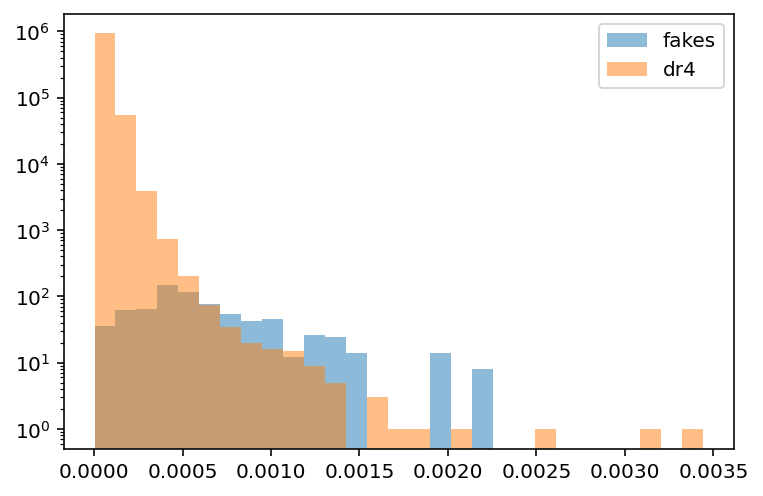

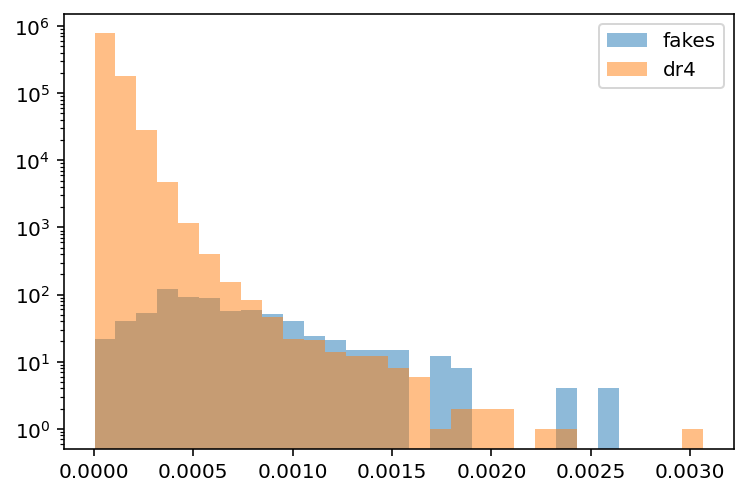

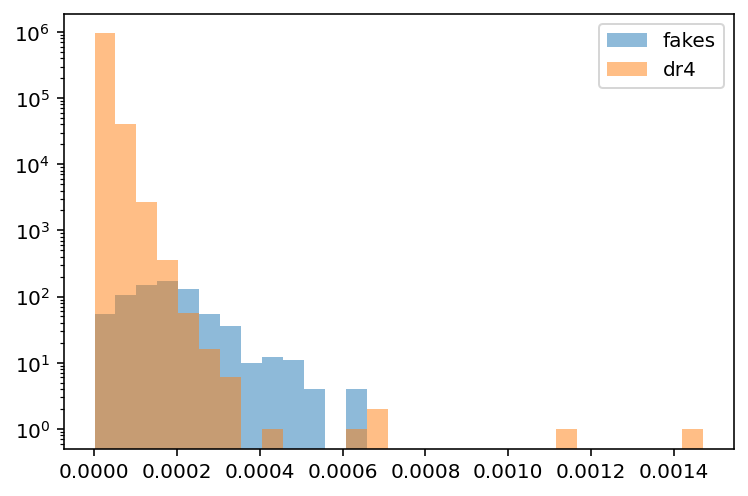

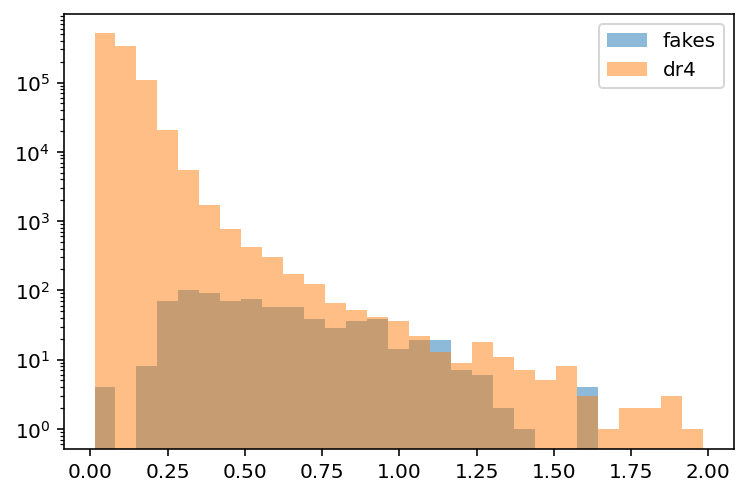

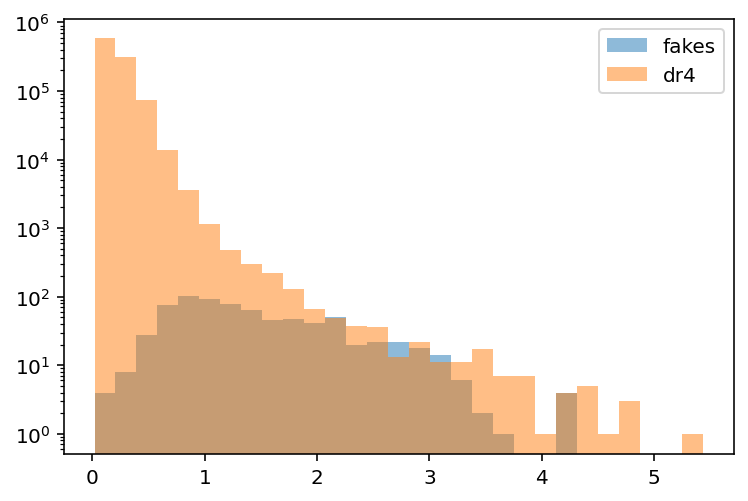

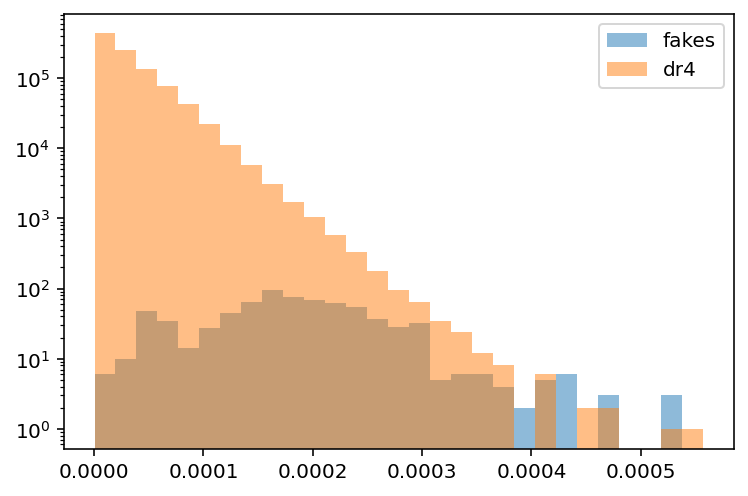

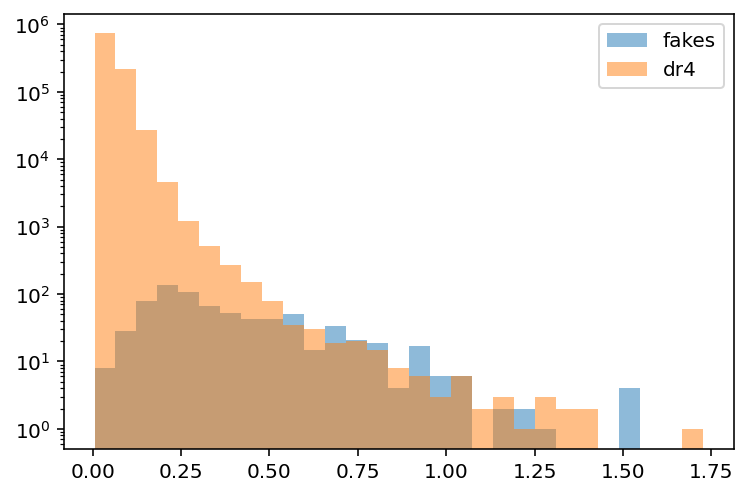

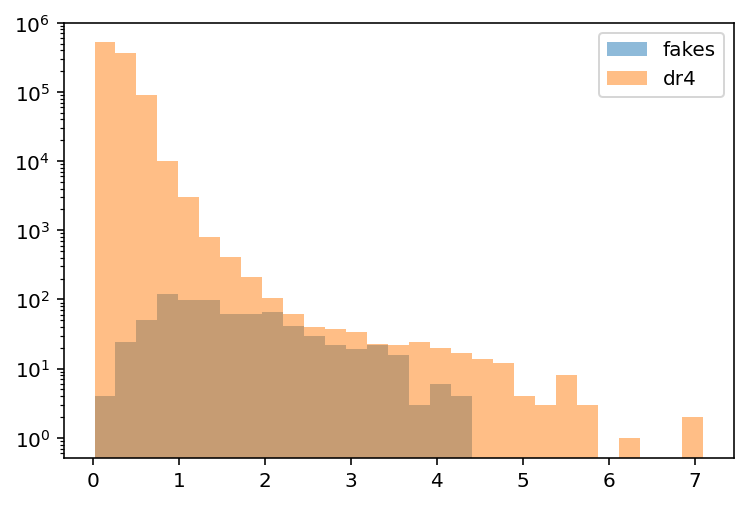

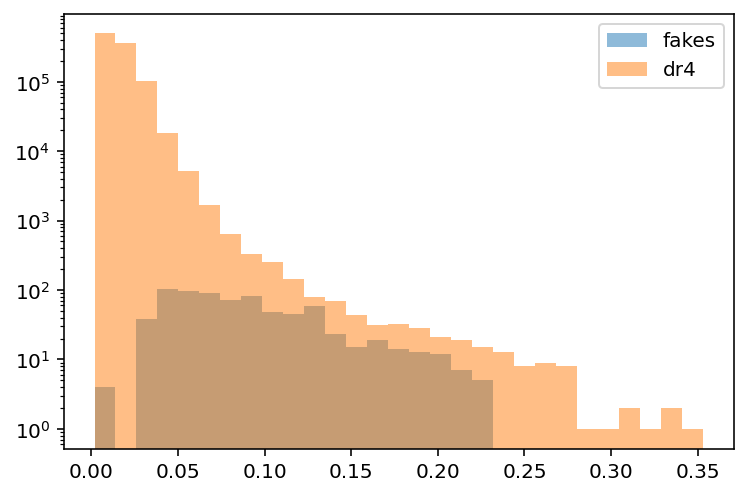

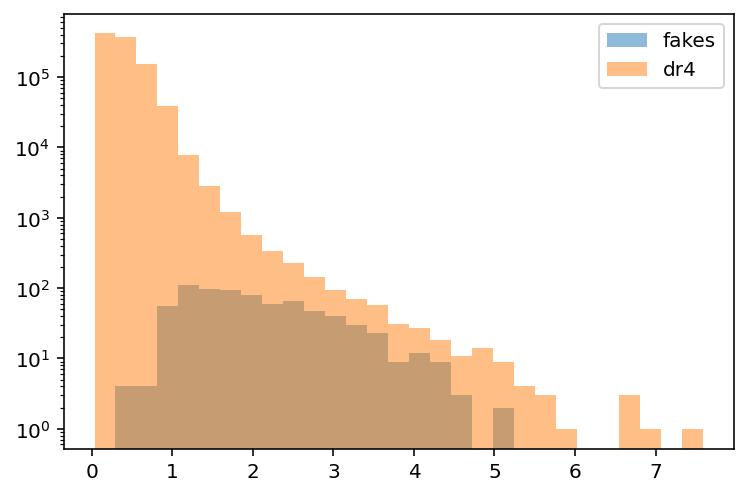

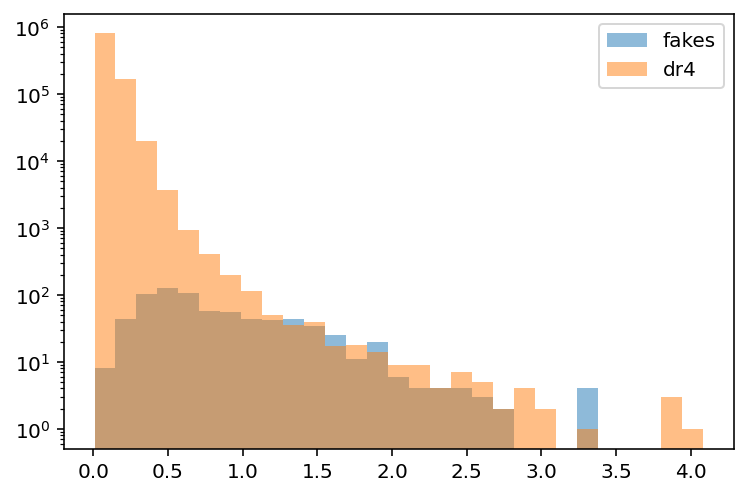

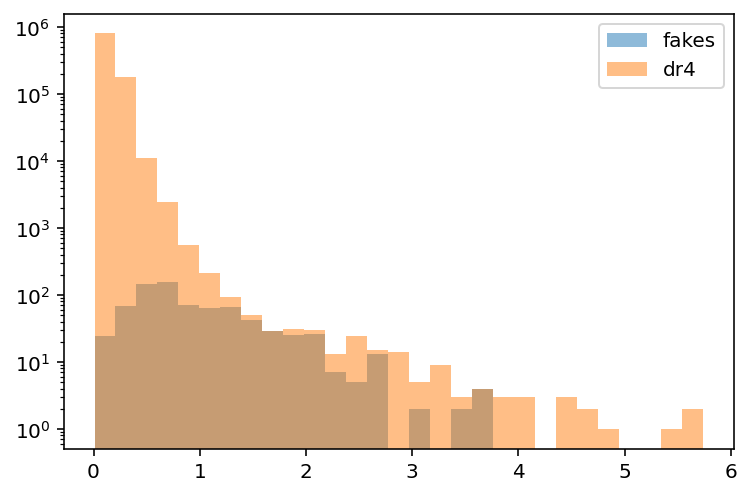

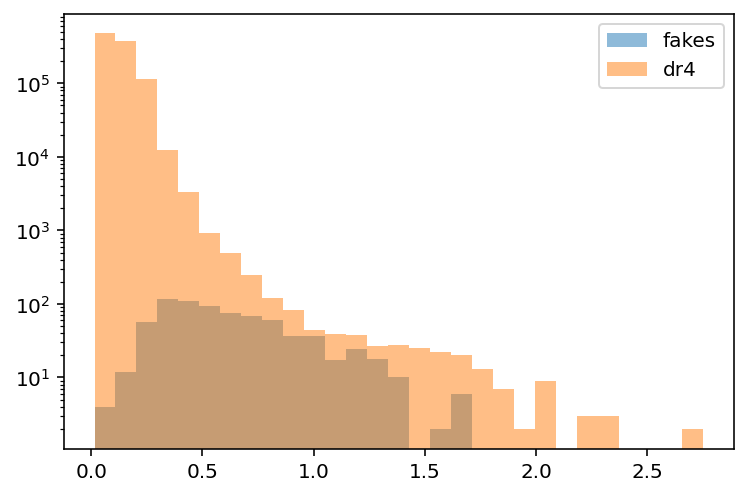

In [19]:
# Find and return only objects where dr4 and fakes overlap for features (so sims reflect reality)

for dr4_vs, fakes_vs, feat in zip(dr4_values_list, fakes_values_list, feature_list):
    
    min_dr4, max_dr4 = min(dr4_vs), max(dr4_vs) 
    fakes_vs = fakes_vs[(fakes_vs > min_dr4) & (fakes_vs < max_dr4)]
    
    bins = np.linspace(min_dr4, max_dr4, 30)
    plt.hist(fakes_vs, bins=bins, alpha=0.5, label='fakes')
    plt.hist(dr4_vs, bins=bins, alpha=0.5, label='dr4')
    plt.yscale('log')
    plt.legend()
    plt.show()

## Take features of real & fakes, drop some features that don't match well between them

In [20]:
dr4_index = [sids > 1e10]
dr4_sids = sids[dr4_index]
dr4_features = features[dr4_index]

fakes_index = [sids < 1e10]
fakes_sids = sids[fakes_index]
fakes_features = features[fakes_index]

<ipython-input-20-1290c42e22d8>:2: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  dr4_sids = sids[dr4_index]
<ipython-input-20-1290c42e22d8>:3: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  dr4_features = features[dr4_index]
<ipython-input-20-1290c42e22d8>:6: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  fakes_sids 

In [21]:
for fid, feat in enumerate(feature_names):
    print(fid, feat)

0 amplitude_magn_g
1 anderson_darling_normal_magn_g
2 beyond_1_std_magn_g
3 beyond_2_std_magn_g
4 cusum_magn_g
5 eta_e_magn_g
6 inter_percentile_range_2_magn_g
7 inter_percentile_range_10_magn_g
8 inter_percentile_range_25_magn_g
9 kurtosis_magn_g
10 linear_fit_slope_magn_g
11 linear_fit_slope_sigma_magn_g
12 linear_fit_reduced_chi2_magn_g
13 linear_trend_magn_g
14 linear_trend_sigma_magn_g
15 magnitude_percentage_ratio_40_5_magn_g
16 magnitude_percentage_ratio_20_5_magn_g
17 maximum_slope_magn_g
18 mean_magn_g
19 median_absolute_deviation_magn_g
20 median_buffer_range_percentage_10_magn_g
21 median_buffer_range_percentage_20_magn_g
22 percent_amplitude_magn_g
23 percent_difference_magnitude_percentile_5_magn_g
24 percent_difference_magnitude_percentile_10_magn_g
25 period_0_magn_g
26 period_s_to_n_0_magn_g
27 period_1_magn_g
28 period_s_to_n_1_magn_g
29 period_2_magn_g
30 period_s_to_n_2_magn_g
31 period_3_magn_g
32 period_s_to_n_3_magn_g
33 period_4_magn_g
34 period_s_to_n_4_magn_g
3

In [22]:
all_feat_nums = list(np.linspace(0,105, 106, dtype=int)) 
bad_feats = list([5, 12, 17, 25, 27, 29, 31, 33, 35, 39, 46, 50, 58, 65, 70, 78, 80, 82, 84, 86, 88, 92, 99, 103])
dropfeat_nums = np.array([x for x in all_feat_nums if x not in bad_feats])
drop_features_list = ['eta_e_magn_g', 
                      'linear_fit_reduced_chi2_magn_g',
                      'maximum_slope_magn_g', 
                      'period_0_magn_g', 
                      'period_1_magn_g',
                      'period_2_magn_g',
                      'period_3_magn_g',
                      'period_4_magn_g',
                      'periodogram_amplitude_magn_g',
                      'chi2_magn_g',
                      'eta_e_flux_g',
                      'chi2_flux_g',
                      'eta_e_magn_r',
                      'linear_fit_reduced_chi2_magn_r',
                      'maximum_slope_magn_r',
                      'period_0_magn_r',
                      'period_1_magn_r',
                      'period_2_magn_r',
                      'period_3_magn_r',
                      'period_4_magn_r',
                      'periodogram_amplitude_magn_r',
                      'chi2_magn_r',
                      'eta_e_flux_r',
                      'chi2_flux_r']
dropfeat_feature_names = [h for h in feature_names if h not in drop_features_list]

In [23]:
roots_dr4_features = dr4_features[:, roots]
roots_fakes_features = fakes_features[:, roots]

dropfeat_dr4_features = dr4_features[:, dropfeat_nums]
dropfeat_fakes_features = fakes_features[:, dropfeat_nums]

dropfeat_all_features = features[:, dropfeat_nums]
dropfeat_all_features = dropfeat_all_features.copy(order='C')

In [24]:
%%time

# Perform calculations of outliers

dropfeat_isoforest = IsolationForest(n_subsamples=1024, n_trees=1000) # n_subsamples=1024, n_trees=1000
dropfeat_isoforest.fit(dropfeat_all_features)
dropfeat_scores = dropfeat_isoforest.score_samples(dropfeat_all_features)
dropfeat_ordered_sids = sids[np.argsort(dropfeat_scores)]
dropfeat_detection_curve = np.cumsum(dropfeat_ordered_sids < 1e10)

CPU times: user 1min 54s, sys: 882 ms, total: 1min 55s
Wall time: 1min 56s


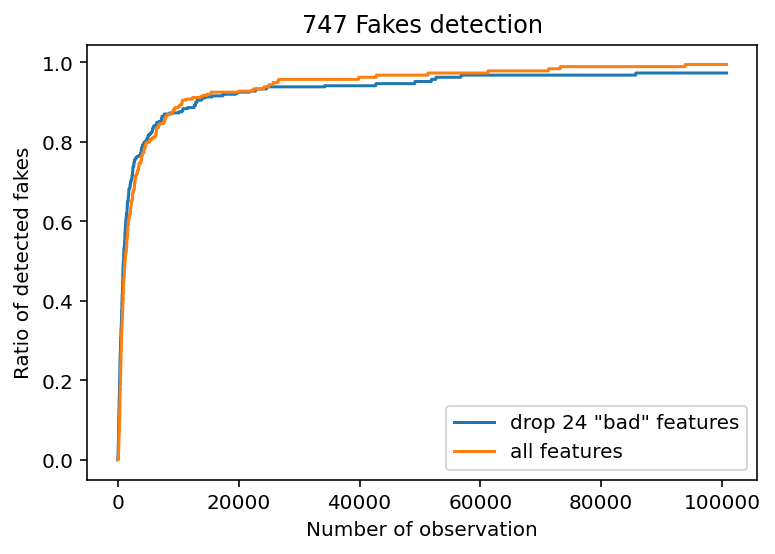

In [25]:
# Plot the detection curve

dropfeat_n_fakes = dropfeat_detection_curve[-1]

plt.plot(dropfeat_detection_curve[:dropfeat_n_fakes+100000]/num_fakes, label=f'drop {len(bad_feats)} \"bad\" features') # 10000 is for extragal_short_gr_100.tar
plt.plot(detection_curve[:n_fakes+100000]/num_fakes, label='all features') # 10000 is for extragal_short_gr_100.tar

plt.xlabel('Number of observation')
plt.ylabel('Ratio of detected fakes')
plt.title(f'{num_fakes} Fakes detection')
plt.legend();
pass

In [26]:
lc_consider = 100000

num_fake_left = n_fakes - detection_curve[lc_consider]
num_fake_left_dropfeat = dropfeat_n_fakes - dropfeat_detection_curve[lc_consider]

print("All features:", num_fake_left, "fakes out of", len(detection_curve), 
      "total at", lc_consider, "which is", lc_consider/len(detection_curve)*100,"% of total objects considered")
print("Drop features:", num_fake_left_dropfeat, "fakes out of", len(dropfeat_detection_curve), 
      "total at", lc_consider, "which is", lc_consider/len(dropfeat_detection_curve)*100,"% of total objects considered")

All features: 4 fakes out of 990967 total at 100000 which is 10.091153388558851 % of total objects considered
Drop features: 20 fakes out of 990967 total at 100000 which is 10.091153388558851 % of total objects considered


In [27]:
len(sids)

990967

In [28]:
len(np.unique(sids))

990520

In [29]:
len(fakesids)

747

In [30]:
len(np.unique(fakesids))

300

## Isolate hard to find remaining fakes and plot!

In [32]:
scores_df = pd.DataFrame(zip(sids, scores, features), columns=['sid', 'score', 'features'])
dropfeat_scores_df = pd.DataFrame(zip(sids, dropfeat_scores, dropfeat_all_features), columns=['sid', 'dropfeat_score', 'dropfeat_all_features'])

sort_scores_df = scores_df[(scores_df.sid < 1e10)].sort_values(by=['score'], ascending=True)
sort_dropfeat_scores_df = dropfeat_scores_df[(dropfeat_scores_df.sid < 1e10)].sort_values(by=['dropfeat_score'], ascending=True)

In [33]:
best_fakes_df = sort_scores_df[:num_fake_left]
best_fakes_df.head()

,sid,score,features
990409,4229763628,-0.747963,"[2.4391327, 3.030501, 0.38655463, 0.0, 0.44821..."
990306,6439074373,-0.745926,"[2.3132715, 6.242598, 0.5442177, 0.0, 0.458068..."
990606,6439074373,-0.745926,"[2.3132715, 6.242598, 0.5442177, 0.0, 0.458068..."
990958,6439074373,-0.745926,"[2.3132715, 6.242598, 0.5442177, 0.0, 0.458068..."


No handles with labels found to put in legend.
No handles with labels found to put in legend.


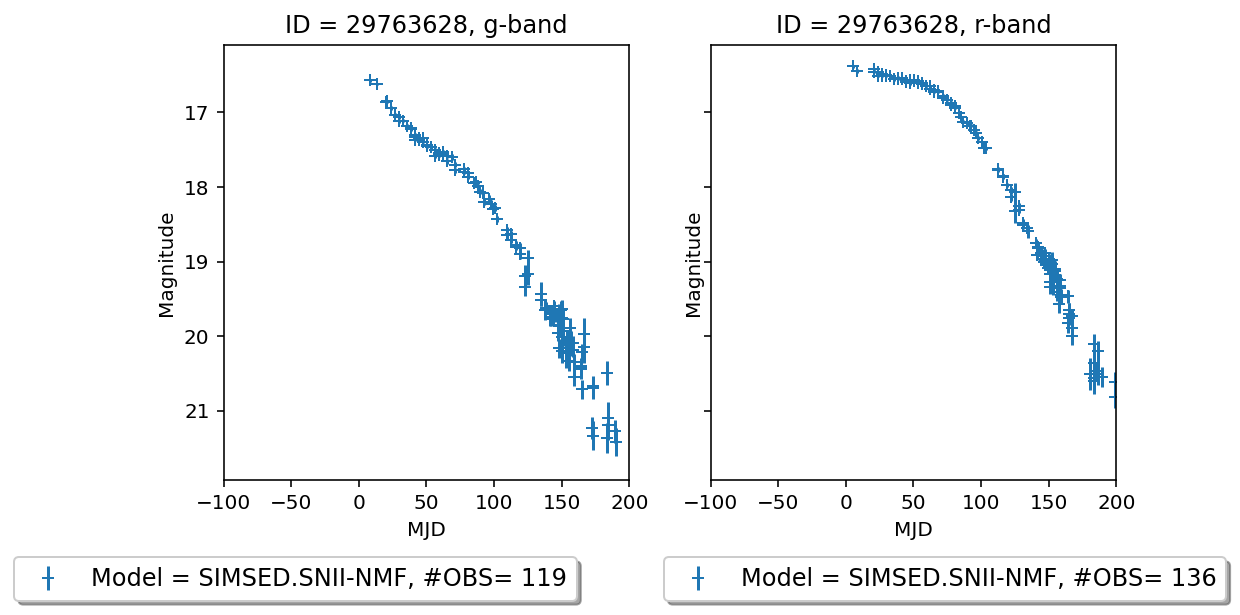

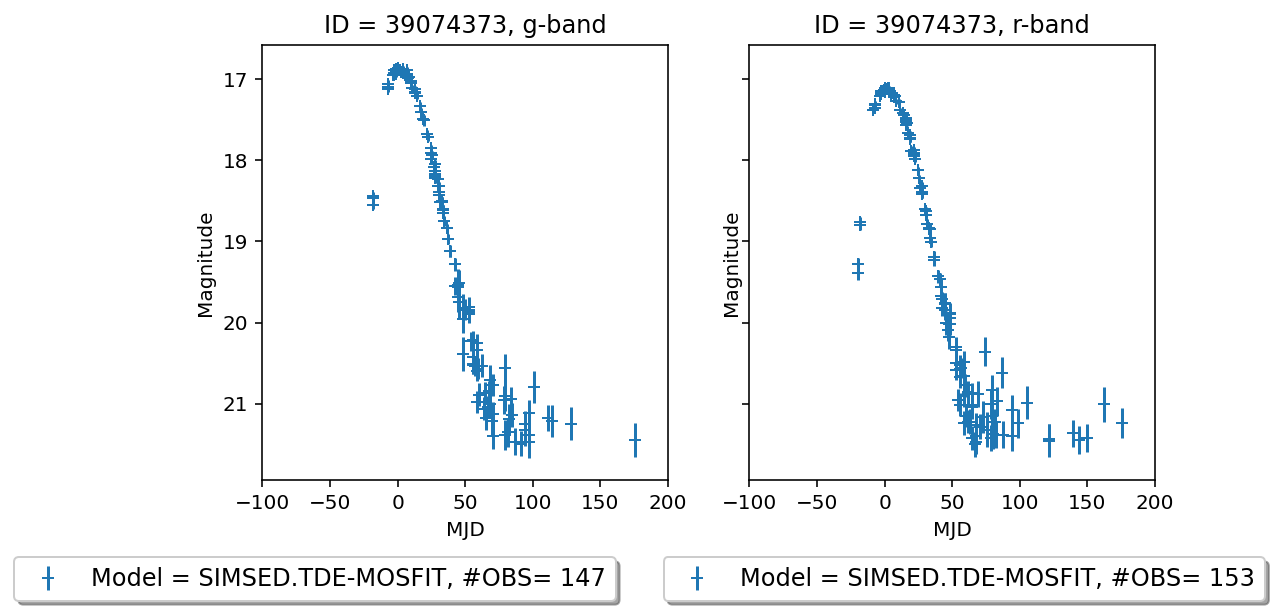

In [34]:
for simid in np.unique(best_fakes_df.sid):
    simid = str(simid) 
    
    # first two digits are class, not actual ID from simulation
    if simid.startswith('42'):  # SN II
        plot_lightcurves_id(int(simid[2:]), X42, 'gr', None) 
        
    elif simid.startswith('60'):  # SLSN-I
        plot_lightcurves_id(int(simid[2:]), X60, 'gr', None) 
        
    elif simid.startswith('62'):  # SLSN-I
        plot_lightcurves_id(int(simid[2:]), X62, 'gr', None)
        
    elif simid.startswith('64'):  # TDE
        plot_lightcurves_id(int(simid[2:]), X64, 'gr', None) 
        
    elif simid.startswith('90'):  # SN Ia
        plot_lightcurves_id(int(simid[2:]), X90, 'gr', None)

In [35]:
best_fakes_dropfeat_df = sort_dropfeat_scores_df[:num_fake_left_dropfeat]
best_fakes_dropfeat_df

,sid,dropfeat_score,dropfeat_all_features
990687,6439074373,-0.772329,"[2.3132715, 6.242598, 0.5442177, 0.0, 0.458068..."
990606,6439074373,-0.772329,"[2.3132715, 6.242598, 0.5442177, 0.0, 0.458068..."
990306,6439074373,-0.772329,"[2.3132715, 6.242598, 0.5442177, 0.0, 0.458068..."
990958,6439074373,-0.772329,"[2.3132715, 6.242598, 0.5442177, 0.0, 0.458068..."
990776,6011793767,-0.768520,"[2.4284763, 16.336357, 0.47265625, 0.0, 0.4489..."
990424,6011793767,-0.768520,"[2.4284763, 16.336357, 0.47265625, 0.0, 0.4489..."
990693,9020928999,-0.766310,"[2.027956, 6.4521065, 0.42944786, 0.0, 0.44402..."
990312,9020928999,-0.766310,"[2.027956, 6.4521065, 0.42944786, 0.0, 0.44402..."
990612,9020928999,-0.766310,"[2.027956, 6.4521065, 0.42944786, 0.0, 0.44402..."
990702,9020928999,-0.766310,"[2.027956, 6.4521065, 0.42944786, 0.0, 0.44402..."


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


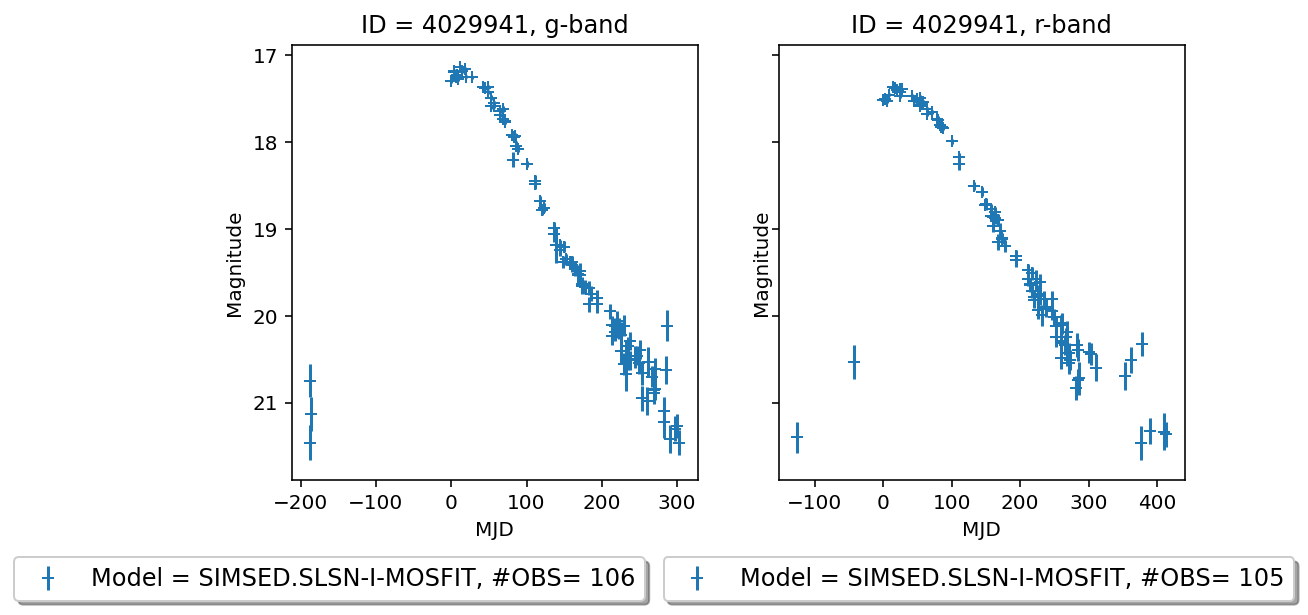

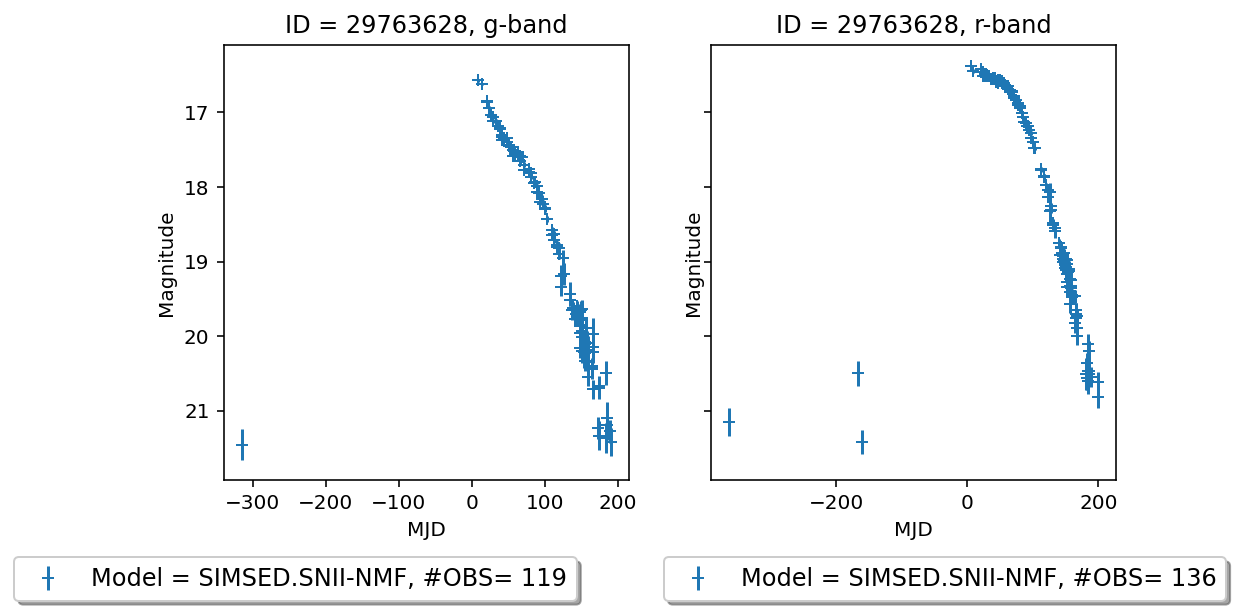

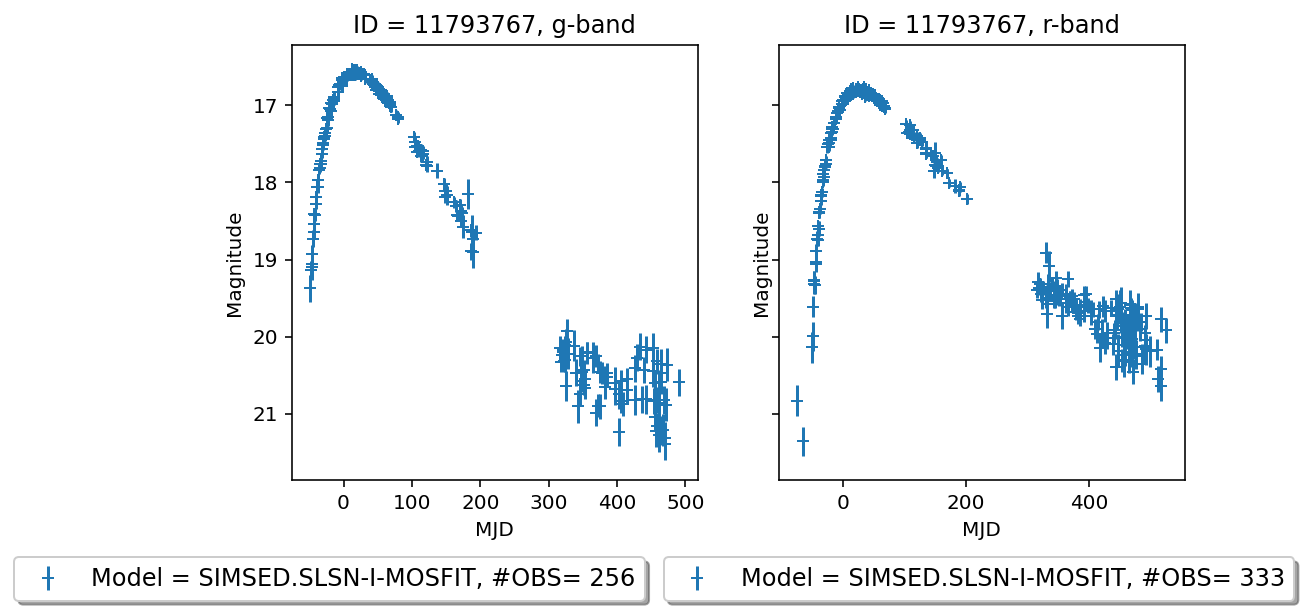

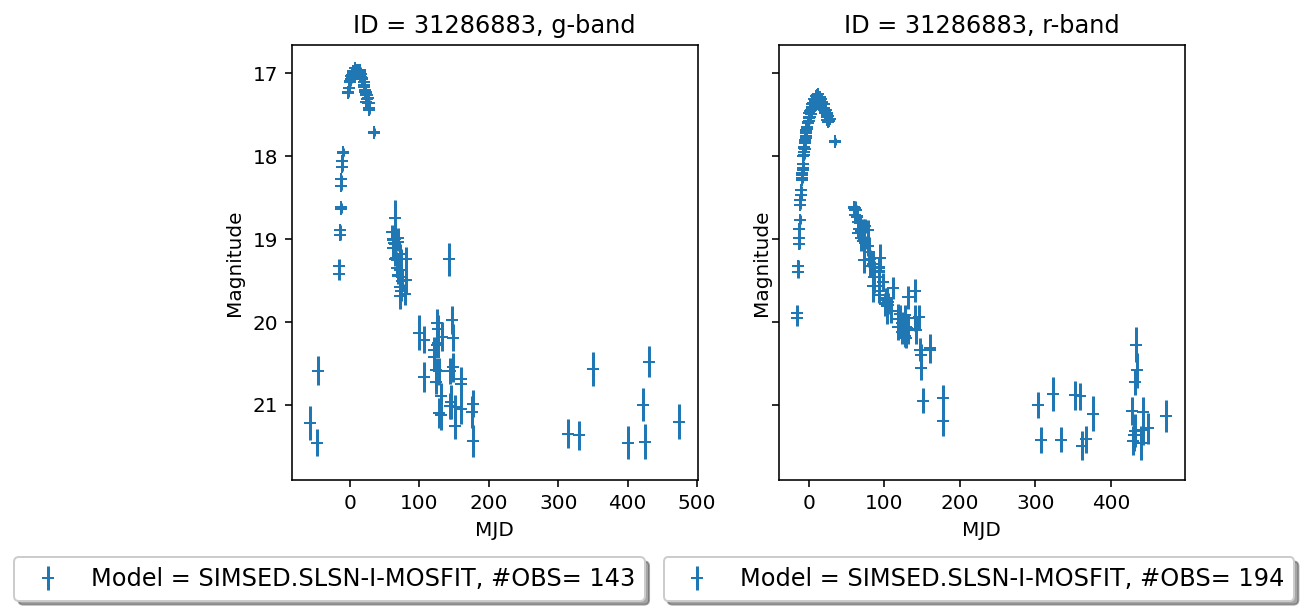

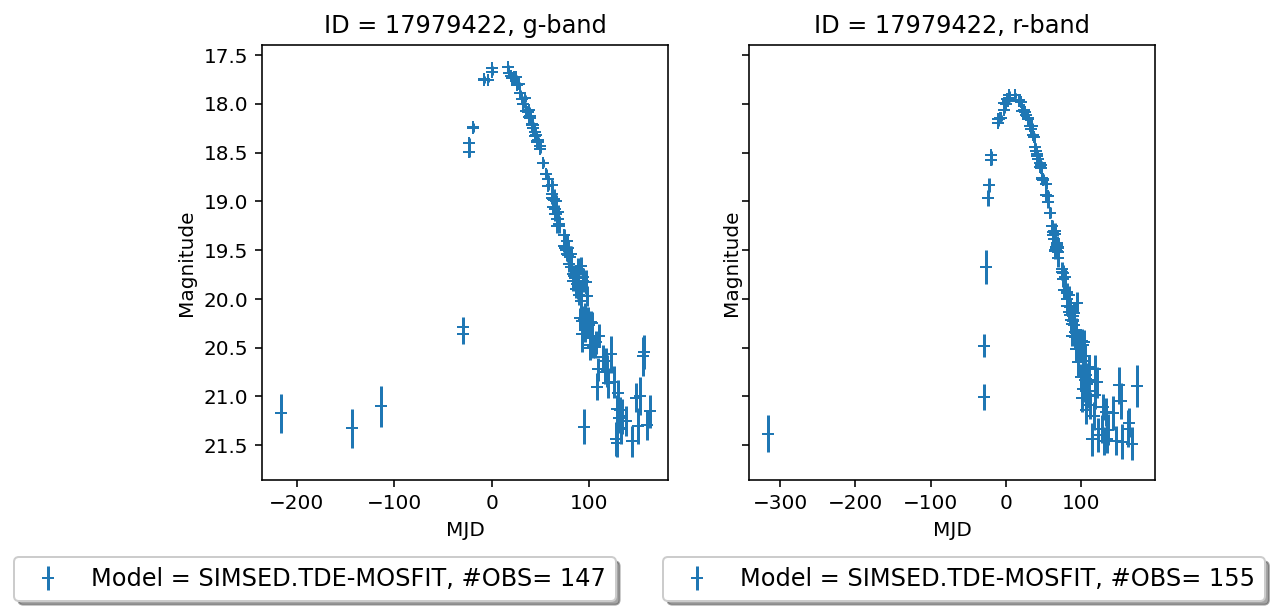

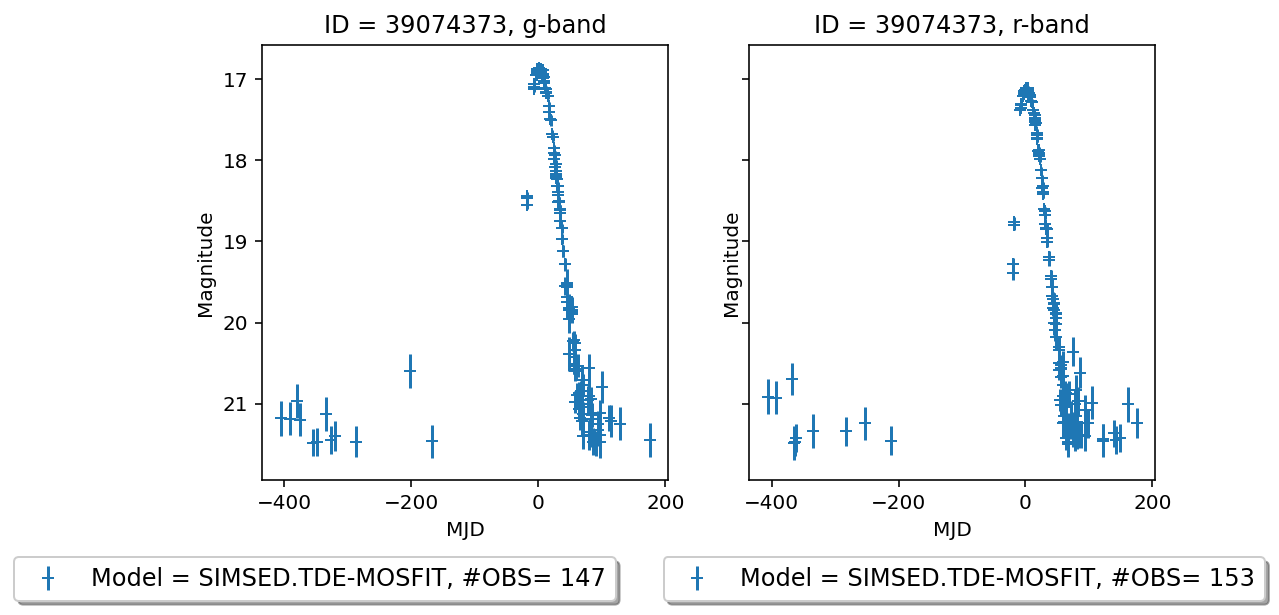

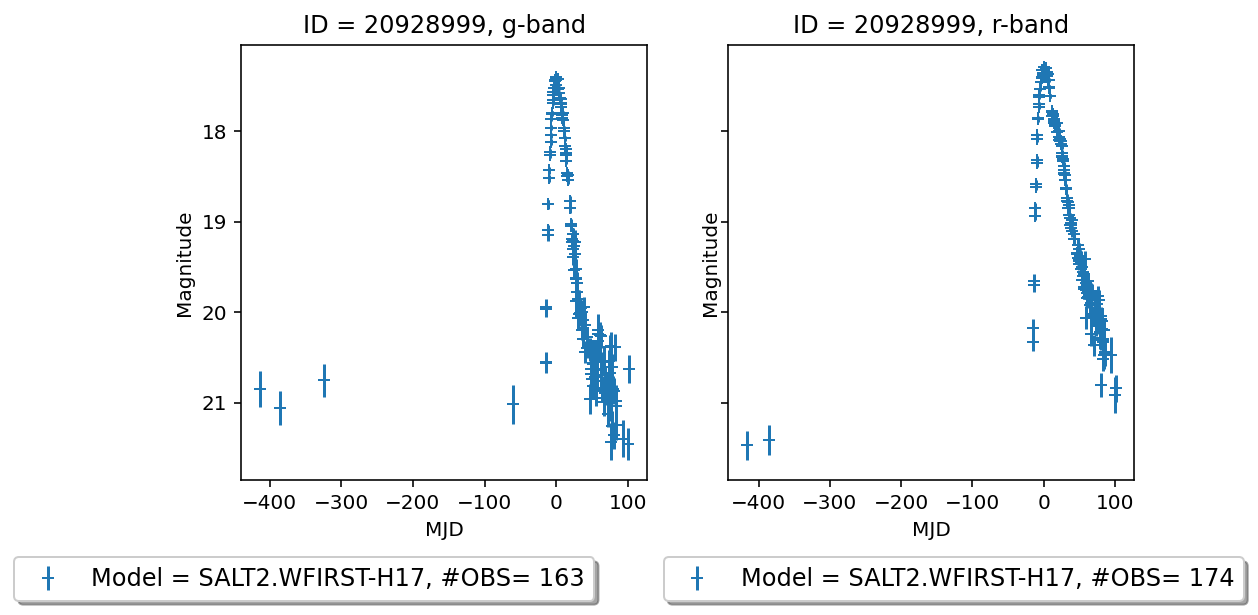

In [43]:
for simid in np.unique(best_fakes_dropfeat_df.sid):
    simid = str(simid) 
    
    # first two digits are class, not actual ID from simulation
    if simid.startswith('42'):  # SN II
        plot_lightcurves_id(int(simid[2:]), X42, 'gr', None) 
        
    elif simid.startswith('60'):  # SLSN-I
        plot_lightcurves_id(int(simid[2:]), X60, 'gr', None) 
        
    elif simid.startswith('62'):  # SLSN-I
        plot_lightcurves_id(int(simid[2:]), X62, 'gr', None)
        
    elif simid.startswith('64'):  # TDE
        plot_lightcurves_id(int(simid[2:]), X64, 'gr', None) 
        
    elif simid.startswith('90'):  # SN Ia
        plot_lightcurves_id(int(simid[2:]), X90, 'gr', None)

## KDTREE to match hardest fakes to find to its closest real data counterpart!

In [37]:
%%time

#from sklearn.neighbors import KDTree
from scipy.spatial import cKDTree

# Hardest to find fakes
best_fakes_dropfeat_X = np.vstack(best_fakes_dropfeat_df.dropfeat_all_features)
best_fakes_dropfeat_kdtree = cKDTree(dropfeat_dr4_features)              
best_fake_dropfeat_dist, best_fake_dropfeat_ind = best_fakes_dropfeat_kdtree.query(best_fakes_dropfeat_X, k=15)

CPU times: user 5.37 s, sys: 909 ms, total: 6.28 s
Wall time: 6.51 s


In [38]:
k_neighbor = 14

print(best_fake_dropfeat_dist[:, k_neighbor])    # drop id; assumes sorted -> see args!
print(best_fake_dropfeat_ind[:, k_neighbor])     # drop id

[13.76481523 13.76481523 13.76481523 13.76481523 14.62764638 14.62764638
 13.77081157 13.77081157 13.77081157 13.77081157 13.77081157 12.03828875
 11.86880257 11.86880257 11.26986193 11.26986193 12.91869939 12.91869939
 12.91869939 12.91869939]
[733430 733430 733430 733430 310057 310057 675288 675288 675288 675288
 675288 729224  45891  45891 980322 980322  49169  49169  49169  49169]


In [39]:
dr4_sids_of_best_fake_dropfeat_dist = dr4_sids[best_fake_dropfeat_ind[:, k_neighbor]]
dr4_features_of_best_fake_dropfeat_dist = dropfeat_dr4_features[best_fake_dropfeat_ind[:, k_neighbor]]

best_fakes_dropfeat_df['dr4_dist_of_best_dropfeat_fake'] = np.array(best_fake_dropfeat_dist[:, k_neighbor])
best_fakes_dropfeat_df['dr4_sids_of_best_dropfeat_fake'] = dr4_sids_of_best_fake_dropfeat_dist

<ipython-input-39-039126dfe2b1>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  best_fakes_dropfeat_df['dr4_dist_of_best_dropfeat_fake'] = np.array(best_fake_dropfeat_dist[:, k_neighbor])
<ipython-input-39-039126dfe2b1>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  best_fakes_dropfeat_df['dr4_sids_of_best_dropfeat_fake'] = dr4_sids_of_best_fake_dropfeat_dist


In [40]:
best_fakes_dropfeat_df

,sid,dropfeat_score,dropfeat_all_features,dr4_dist_of_best_dropfeat_fake,dr4_sids_of_best_dropfeat_fake
990687,6439074373,-0.772329,"[2.3132715, 6.242598, 0.5442177, 0.0, 0.458068...",13.764815,793107200002055
990606,6439074373,-0.772329,"[2.3132715, 6.242598, 0.5442177, 0.0, 0.458068...",13.764815,793107200002055
990306,6439074373,-0.772329,"[2.3132715, 6.242598, 0.5442177, 0.0, 0.458068...",13.764815,793107200002055
990958,6439074373,-0.772329,"[2.3132715, 6.242598, 0.5442177, 0.0, 0.458068...",13.764815,793107200002055
990776,6011793767,-0.768520,"[2.4284763, 16.336357, 0.47265625, 0.0, 0.4489...",14.627646,677112100002841
990424,6011793767,-0.768520,"[2.4284763, 16.336357, 0.47265625, 0.0, 0.4489...",14.627646,677112100002841
990693,9020928999,-0.766310,"[2.027956, 6.4521065, 0.42944786, 0.0, 0.44402...",13.770812,766111300018322
990312,9020928999,-0.766310,"[2.027956, 6.4521065, 0.42944786, 0.0, 0.44402...",13.770812,766111300018322
990612,9020928999,-0.766310,"[2.027956, 6.4521065, 0.42944786, 0.0, 0.44402...",13.770812,766111300018322
990702,9020928999,-0.766310,"[2.027956, 6.4521065, 0.42944786, 0.0, 0.44402...",13.770812,766111300018322


In [41]:
for featid, feat in enumerate(dropfeat_feature_names):
    print(f'{featid} {feat} DR4:', dr4_features_of_best_fake_dropfeat_dist[15][featid], 'FAKE:',  np.vstack(best_fakes_dropfeat_df.dropfeat_all_features)[15][featid], 
         '\n DIFFERENCE:', dr4_features_of_best_fake_dropfeat_dist[15][featid]- np.vstack(best_fakes_dropfeat_df.dropfeat_all_features)[15][featid], '\n')

0 amplitude_magn_g DR4: 0.6489992 FAKE: 2.1640024 
 DIFFERENCE: -1.5150032 

1 anderson_darling_normal_magn_g DR4: 3.6388462 FAKE: 2.8231137 
 DIFFERENCE: 0.8157325 

2 beyond_1_std_magn_g DR4: 0.36312848 FAKE: 0.4245283 
 DIFFERENCE: -0.061399817 

3 beyond_2_std_magn_g DR4: 0.022346368 FAKE: 0.0 
 DIFFERENCE: 0.022346368 

4 cusum_magn_g DR4: 0.37704587 FAKE: 0.42919528 
 DIFFERENCE: -0.052149415 

5 inter_percentile_range_2_magn_g DR4: 1.0663605 FAKE: 4.264567 
 DIFFERENCE: -3.1982064 

6 inter_percentile_range_10_magn_g DR4: 0.7649994 FAKE: 3.5739865 
 DIFFERENCE: -2.8089871 

7 inter_percentile_range_25_magn_g DR4: 0.4742489 FAKE: 2.5233498 
 DIFFERENCE: -2.0491009 

8 kurtosis_magn_g DR4: -0.70039916 FAKE: -1.250747 
 DIFFERENCE: 0.5503478 

9 linear_fit_slope_magn_g DR4: -0.0017110582 FAKE: 0.01315758 
 DIFFERENCE: -0.0148686385 

10 linear_fit_slope_sigma_magn_g DR4: 6.0508413e-05 FAKE: 6.600821e-05 
 DIFFERENCE: -5.4997945e-06 

11 linear_trend_magn_g DR4: -0.0017237039 FAKE: 

IndexError: index 82 is out of bounds for axis 0 with size 82

## TODO: LOOK INTO WHY THERE ARE DUPLICATE FAKE IDS!
## TODO: remove the easiest to find fakes and redo detection plot

(array([   9.,   44.,  115.,  272.,  643., 1340., 2566., 4129., 3094.,
         410.]),
 array([15.69459438, 16.30708952, 16.91958466, 17.53207979, 18.14457493,
        18.75707006, 19.3695652 , 19.98206034, 20.59455547, 21.20705061,
        21.81954575]),
 <BarContainer object of 10 artists>)

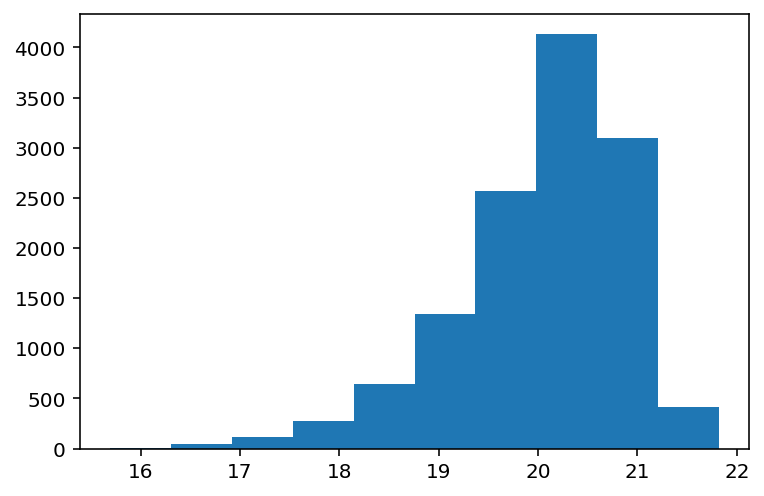

In [52]:
plt.hist(np.hstack(X42.pkmag_g))

(array([2.000e+00, 6.000e+00, 2.100e+01, 8.600e+01, 3.050e+02, 9.290e+02,
        2.550e+03, 4.930e+03, 3.733e+03, 3.180e+02]),
 array([13.58069897, 14.42974119, 15.27878342, 16.12782564, 16.97686787,
        17.82591009, 18.67495232, 19.52399454, 20.37303677, 21.22207899,
        22.07112122]),
 <BarContainer object of 10 artists>)

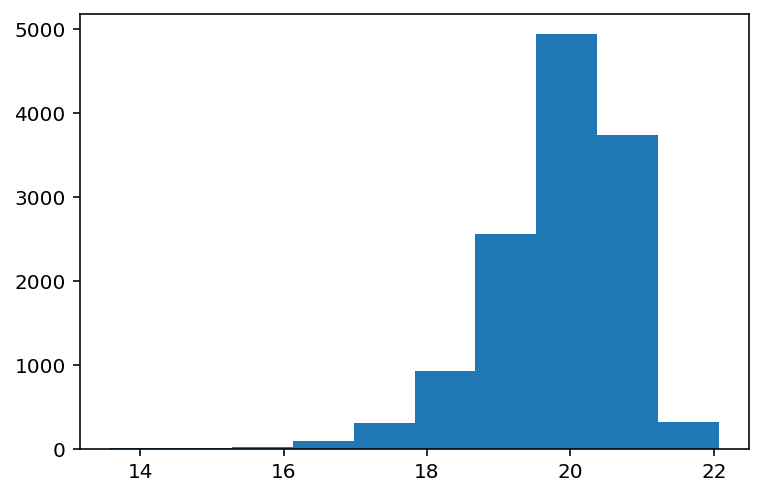

In [53]:
plt.hist(np.hstack(X60.pkmag_g))

(array([2.000e+00, 2.300e+01, 6.200e+01, 1.620e+02, 4.390e+02, 9.920e+02,
        2.110e+03, 3.995e+03, 3.467e+03, 3.350e+02]),
 array([14.17488194, 14.96565676, 15.75643158, 16.5472064 , 17.33798122,
        18.12875605, 18.91953087, 19.71030569, 20.50108051, 21.29185534,
        22.08263016]),
 <BarContainer object of 10 artists>)

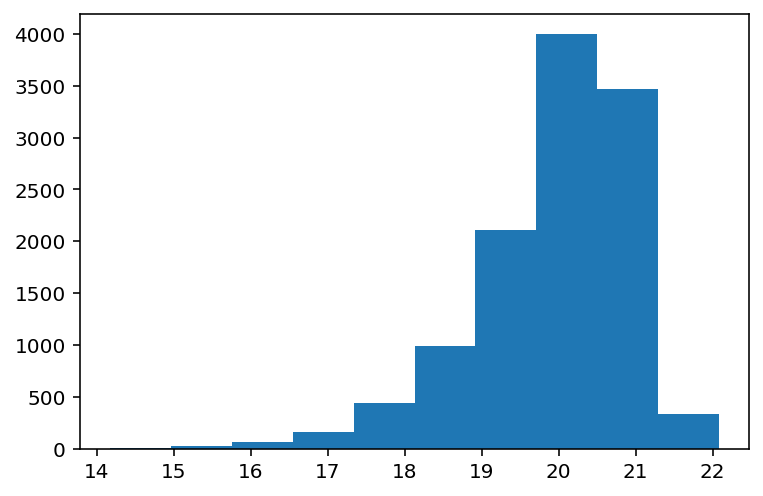

In [54]:
plt.hist(np.hstack(X90.pkmag_g))

## simulations high quality plot for paper 

In [144]:
def sim_plot_paper(idx, X):  
    fig, ax = plt.subplots(figsize=(8, 6))
    plt.gca().invert_yaxis()

    ax.errorbar(X.loc[idx]['mjd_g'] - X.loc[idx]['pkmjd'], 
                 X.loc[idx]['mag_g'], 
                 X.loc[idx]['magerr_g'], 
                 fmt='o', 
                 color='#1a9850',
                 ms=5,
                 alpha=0.5,
                 label='$zg$-band, NOBS={}'.format(len(X.loc[idx]['mjd_g']))) 
    
    ax.errorbar(X.loc[idx]['mjd_r'] - X.loc[idx]['pkmjd'], 
                 X.loc[idx]['mag_r'], 
                 X.loc[idx]['magerr_r'], 
                 fmt='o', 
                 color='#d73027',
                 ms=5,
                 alpha=0.5,
                 label='$zr$-band, NOBS={}'.format(len(X.loc[idx]['mjd_r']))) 

    ax.set_xlim(-75,100)
    ax.set_ylim(21.5,17)
    ax.set_xlabel('Days to $zr$-band peak', fontsize=14)
    ax.set_ylabel('Magnitude', fontsize=14)
    ax.set_title('ZTF SNIa model', fontsize=14)
    
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.legend(loc='best', ncol=1, fancybox=True, shadow=False, fontsize=12)

    plt.savefig('./figures/ztf_snia_model_sim.pdf', dpi=300, bbox_inches='tight')

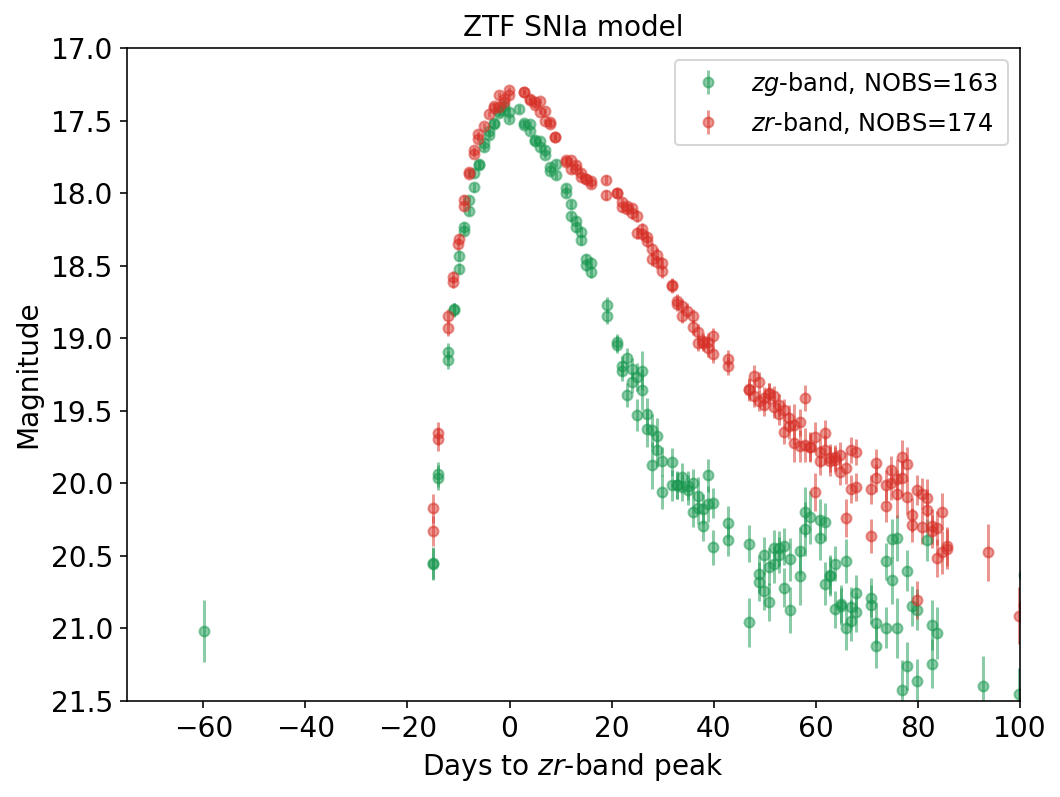

In [145]:
sim_plot_paper(20928999, X90)